In [ ]:
"""
from google.colab import files
import os
import shutil

uploaded = files.upload()
dest_path = "/content/data/"
os.makedirs(os.path.dirname(dest_path), exist_ok=True)
shutil.move("/content/InputDataEnergyLargeInstance.xlsx", dest_path)
#shutil.move("/content/InputDataEnergySmallInstance.xlsx", dest_path)
shutil.rmtree("/content/sample_data/", ignore_errors=True, onerror=None)
"""

Saving InputDataEnergyLargeInstance.xlsx to InputDataEnergyLargeInstance.xlsx


In [ ]:
!pip install pulp
!pip install networkx matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 30.0 MB/s eta 0:00:00


In [ ]:
# Import PuLP modeler functions
from pulp import *
import pandas as pd
import numpy as np

In [ ]:
InputData = "/content/data/InputDataEnergyLargeInstance.xlsx"  # Large instance

In [ ]:
# Input Data Preparation
def read_excel_data(filename, sheet_name):
  data = pd.read_excel(filename, sheet_name=sheet_name, header=None)
  values = data.values
  if min(values.shape) == 1:  # This If is to make the code insensitive to column-wise or row-wise expression
      if values.shape[0] == 1:
          values = values.tolist()
      else:
          values = values.transpose()
          values = values.tolist()
      return values[0]
  else:
      data_dict = {}
      if min(values.shape) == 2:  # For single-dimension parameters in Excel
          if values.shape[0] == 2:
              for i in range(values.shape[1]):
                  data_dict[i] = values[1][i]
          else:
              for i in range(values.shape[0]):
                  data_dict[i] = (values[i][0],values[i][1])

      else:  # For two-dimension (matrix) parameters in Excel
          for i in range(values.shape[0]):
              for j in range(values.shape[1]):
                  data_dict[(i, j)] = values[i][j]
      return data_dict

{(0, 0): np.int64(0), (0, 1): np.int64(5), (0, 2): np.int64(2), (0, 3): np.int64(9), (0, 4): np.int64(6), (0, 5): np.int64(6), (0, 6): np.int64(4), (0, 7): np.int64(6), (0, 8): np.int64(6), (0, 9): np.int64(7), (0, 10): np.int64(8), (0, 11): np.int64(5), (0, 12): np.int64(5), (0, 13): np.int64(4), (0, 14): np.int64(7), (0, 15): np.int64(9), (0, 16): np.int64(6), (0, 17): np.int64(9), (0, 18): np.int64(7), (0, 19): np.int64(6), (0, 20): np.int64(9), (0, 21): np.int64(9), (0, 22): np.int64(7), (0, 23): np.int64(8), (0, 24): np.int64(5), (0, 25): np.int64(5), (0, 26): np.int64(4), (0, 27): np.int64(8), (0, 28): np.int64(7), (0, 29): np.int64(9), (1, 0): np.int64(5), (1, 1): np.int64(0), (1, 2): np.int64(8), (1, 3): np.int64(9), (1, 4): np.int64(7), (1, 5): np.int64(6), (1, 6): np.int64(8), (1, 7): np.int64(8), (1, 8): np.int64(9), (1, 9): np.int64(5), (1, 10): np.int64(9), (1, 11): np.int64(5), (1, 12): np.int64(8), (1, 13): np.int64(6), (1, 14): np.int64(8), (1, 15): np.int64(9), (1, 16)

In [ ]:
#parameters
Nodes = read_excel_data(InputData, "Nodes")
NodesCord = read_excel_data(InputData, "NodesCord")
V = [i for i in range(0,Nodes[0])]
E = [(i, j) for i in range(0, Nodes[0] ) for j in range(0, Nodes[0] )]
l={}
for i in range(Nodes[0]):
    for j in range(Nodes[0]):
        l[(i,j)]=((NodesCord[i][0]-NodesCord[j][0])**2+(NodesCord[i][1]-NodesCord[j][1])**2)**(1/2)

V0 = read_excel_data(InputData, "SourceNum")
for i in range(len(V0)):
  V0[i]=V0[i]-1
FixedUnitCost = read_excel_data(InputData, "FixedUnitCost")
SourceNum = read_excel_data(InputData, "SourceNum")
vfix_thetaijfix = read_excel_data(InputData, "vfix(thetaijfix)")
vvar_thetaijvar = read_excel_data(InputData, "vvar(thetaijvar)")
cvar_cijvar = read_excel_data(InputData, "cvar(cijvar)")
cheat_ciheat = read_excel_data(InputData, "cheat(ciheat)")
com_cijom = read_excel_data(InputData, "com(cijom)")
crev_cijrev = read_excel_data(InputData, "crev(cijrev)")
Tflh_Tiflh = read_excel_data(InputData, "Tflh(Tiflh)")
Betta = read_excel_data(InputData, "Betta")
Lambda = read_excel_data(InputData, "Lambda")
Alpha = read_excel_data(InputData, "Alpha")
EdgesDemandPeak_dij = read_excel_data(InputData, "EdgesDemandPeak(dij)")
EdgesDemandAnnual_dij =  read_excel_data(InputData, "EdgesDemandAnnual(Dij)")
Cmax_cijmax = read_excel_data(InputData, "Cmax(cijmax)")
SourceMaxCap_Qimax = read_excel_data(InputData, "SourceMaxCap(Qimax)")
pumd_pijumd = read_excel_data(InputData, "pumd(pijumd)")

In [ ]:
#decision variables
X=LpVariable.dicts("X",(V,V),lowBound=0,upBound=1,cat="Binary")
P_Out=LpVariable.dicts("P_Out",(V,V),lowBound=0,upBound=None,cat="Continuous")
P_In=LpVariable.dicts("P_In",(V,V),lowBound=0,upBound=None,cat="Continuous")
problem=LpProblem("problem",LpMinimize)

In [ ]:

# Constraint 1 : ne fonctionne plus car graphe plus un arbre
"""
sum_x =[]
for i in range(len(V)):
  for j in range(len(V)):
    sum_x.append(X[i][j])
problem += lpSum([X[i][j] for i in range(len(V)) for j in range(len(V))]) == len(V) - 1
"""

# Constraint 2 : je laisse comme ca maintenant
for i in range(len(V)):
    for j in range(i+1,len(V)):
        problem += lpSum([X[i][j],X[j][i]]) <= 1

# Constraint 3 : rien a changer
for (i,j) in E:
    eta = 1 - vvar_thetaijvar[(i,j)]*l[(i,j)]
    delta = EdgesDemandPeak_dij[(i,j)]*Betta[0]*Lambda[0] + l[(i,j)]*vfix_thetaijfix[(i,j)]
    problem += lpSum([eta*P_In[i][j],-P_Out[i][j],-delta*X[i][j]]) == 0

# Constraint 4
"""for j in range(4,len(V)):
    sum_out_in= []
    for i in range(len(V)):
        if i != j:
            sum_out_in.append(P_Out[i][j])
            sum_out_in.append(-P_In[j][i])
            problem +=lpSum(sum_out_in) == 0"""
for j in range(0,len(V)):
  if j not in V0:
    problem += lpSum(P_Out[i][j]-P_In[j][i] for i in range(len(V)) if i != j) == 0

# Constraint 5
for i in range(len(V)):
  for j in range(len(V)):
    problem += lpSum([P_In[i][j],-X[i][j]*Cmax_cijmax[(i,j)] ]) <= 0

# Constraint 6
for v in V0:
  for i in range(len(V)):
    if i != v:
      problem += X[i][v] == 0
      problem += P_In[i][v] == 0
"""problem += sum_X == 0"""

# Constraint 7
for v in V0:
  sum_PIN =[]
  for i in range(len(V)):
      if i != v:
          sum_PIN.append(P_In[v][i])
  problem += lpSum(sum_PIN) <= SourceMaxCap_Qimax[0]

# Constraint 8 : il faut laisser celle ci

for i in range(0,len(V)):
  if i not in V0:
    summ=[]
    for j in range(len(V)):
        if j!=i:
          summ.append(X[j][i])
    problem += lpSum(summ) >= 1


# Constraint 9
for i in range(len(V)):
  for j in range(len(V)):
    problem += P_In[i][j] >= 0
    problem += P_Out[i][j] >= 0
    problem += X[i][j] >= 0
    problem += X[i][j] <= 1

# Constraint 10 : nouvelle contrainte qui garantit que chaque vertex ait au moins 3 entree et sorties
for j in range(len(V)):
    # Contrainte : Somme des arêtes entrantes (i -> j, i ≠ j) + arêtes sortantes (j -> k) ≥ 3
    problem += (
        lpSum(X[i][j] for i in V if i != j) +            # Arêtes entrantes (exclut les boucles i=j)
        lpSum(X[j][k] for k in V if k != j)              # Arêtes sortantes (exclut les boucles i=j)
    ) >= 3

In [ ]:
#objective function
n=len(V)

#revenue
revenue=0
for i in range(n):
  for j in range(n):
    revenue+=crev_cijrev[(i,j)]*EdgesDemandAnnual_dij[(i,j)]*Lambda[0]*X[i][j]

#Heat generation
heat_generation=0
for j in range(n):
  for v in V0:
    heat_generation+=P_In[v][j]*Tflh_Tiflh[0]*cheat_ciheat[v]
heat_generation=(1/Betta[0])*heat_generation

#maintenance
maintenance=0
for i in range(n):
  for j in range(n):
    maintenance+=com_cijom[(i,j)]*l[(i,j)]*X[i][j]

#total fixed investment cost
total_fixed_investment_cost=0
for i in range(Nodes[0]):
    for j in range(Nodes[0]):
        total_fixed_investment_cost+=l[(i,j)]*FixedUnitCost[0]*X[i][j]*Alpha[0]

#total variable investment cost
total_var=0
for i in range(n):
  for j in range(n):
    total_var+=cvar_cijvar[(i,j)]*P_In[i][j]*l[(i,j)]*Alpha[0]

#unmet demand
"""
unmet_demand=0
for i in range(n):
  for j in range(i+1,n):
    unmet_demand+=lpSum([1,-X[i][j],-X[j][i]])*pumd_pijumd[(i,j)]*EdgesDemandAnnual_dij[(i,j)]
"""
#objective function
objective_function=-(revenue-heat_generation-maintenance-total_fixed_investment_cost-total_var)
problem+=objective_function
problem.solve()
LpStatus[problem.status]

for var in problem.variables():
    if var.name.endswith("_24") and var.varValue == 1:
      print(var.name,"=",var.varValue )

X_18_24 = 1.0
X_22_24 = 1.0
X_2_24 = 1.0


In [ ]:
for v in problem.variables():
  print(v.name,"=",v.varValue )
print("objective_function","=",value(problem.objective))


P_In_0_0 = 0.0
P_In_0_1 = 0.0
P_In_0_10 = 0.0
P_In_0_11 = 0.0
P_In_0_12 = 0.0
P_In_0_13 = 0.0
P_In_0_14 = 0.0
P_In_0_15 = 0.0
P_In_0_16 = 0.0
P_In_0_17 = 0.0
P_In_0_18 = 0.0
P_In_0_19 = 0.0
P_In_0_2 = 0.0
P_In_0_20 = 0.0
P_In_0_21 = 0.0
P_In_0_22 = 0.0
P_In_0_23 = 0.0
P_In_0_24 = 0.0
P_In_0_25 = 362.41634
P_In_0_26 = 0.0
P_In_0_27 = 0.0
P_In_0_28 = 0.0
P_In_0_29 = 0.0
P_In_0_3 = 0.0
P_In_0_4 = 0.0
P_In_0_5 = 0.0
P_In_0_6 = 592.65602
P_In_0_7 = 0.0
P_In_0_8 = 0.0
P_In_0_9 = 0.0
P_In_10_0 = 0.0
P_In_10_1 = 0.0
P_In_10_10 = 0.0
P_In_10_11 = 0.0
P_In_10_12 = 0.0
P_In_10_13 = 0.0
P_In_10_14 = 0.0
P_In_10_15 = 0.0
P_In_10_16 = 0.0
P_In_10_17 = 0.0
P_In_10_18 = 0.0
P_In_10_19 = 0.0
P_In_10_2 = 0.0
P_In_10_20 = 0.0
P_In_10_21 = 0.0
P_In_10_22 = 0.0
P_In_10_23 = 0.0
P_In_10_24 = 0.0
P_In_10_25 = 0.0
P_In_10_26 = 0.0
P_In_10_27 = 0.0
P_In_10_28 = 0.0
P_In_10_29 = 0.0
P_In_10_3 = 0.0
P_In_10_4 = 0.0
P_In_10_5 = 0.0
P_In_10_6 = 0.0
P_In_10_7 = 1770.0429
P_In_10_8 = 203.02628
P_In_10_9 = 0.0
P_In_1

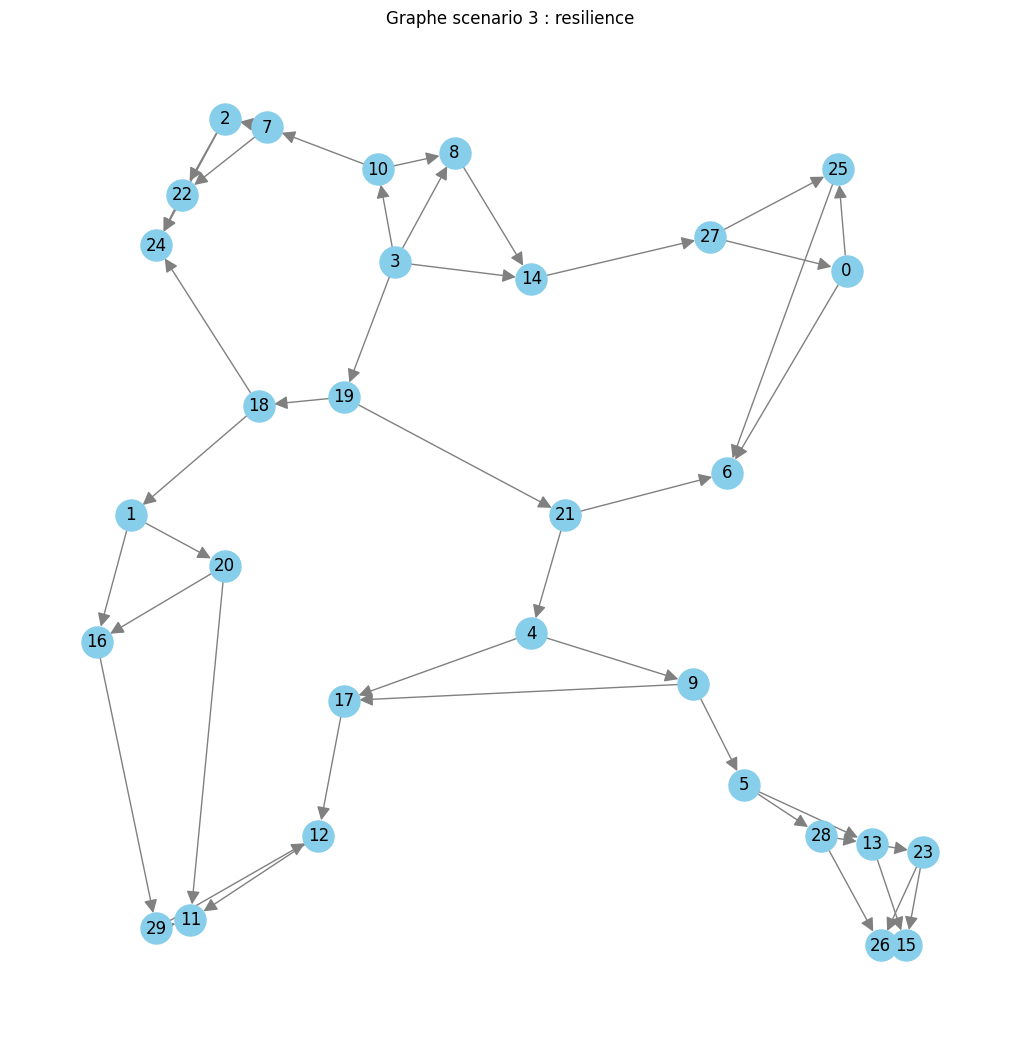

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Extract edges from the solution
edges = []
for var in problem.variables():
    if var.name.startswith("X_") and var.varValue == 1:
        # Parse indices (e.g., "X_0_25" -> (0, 25))
        parts = var.name.split("_")
        i = int(parts[1])
        j = int(parts[2])
        edges.append((i, j))

# Create a directed graph
G = nx.DiGraph()

# Add nodes
G.add_nodes_from(V)

# Add edges
G.add_edges_from(edges)

# Extract node coordinates from NodesCord (convert np.int64 to float)
pos = {node: (float(NodesCord[node][0]), float(NodesCord[node][1])) for node in NodesCord}

# Draw the graph
plt.figure(figsize=(10, 10))
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=500,
        edge_color='gray', arrows=True, arrowsize=20)
plt.title("Graphe scenario 3 : resilience")
plt.show()

[(0, 5)]


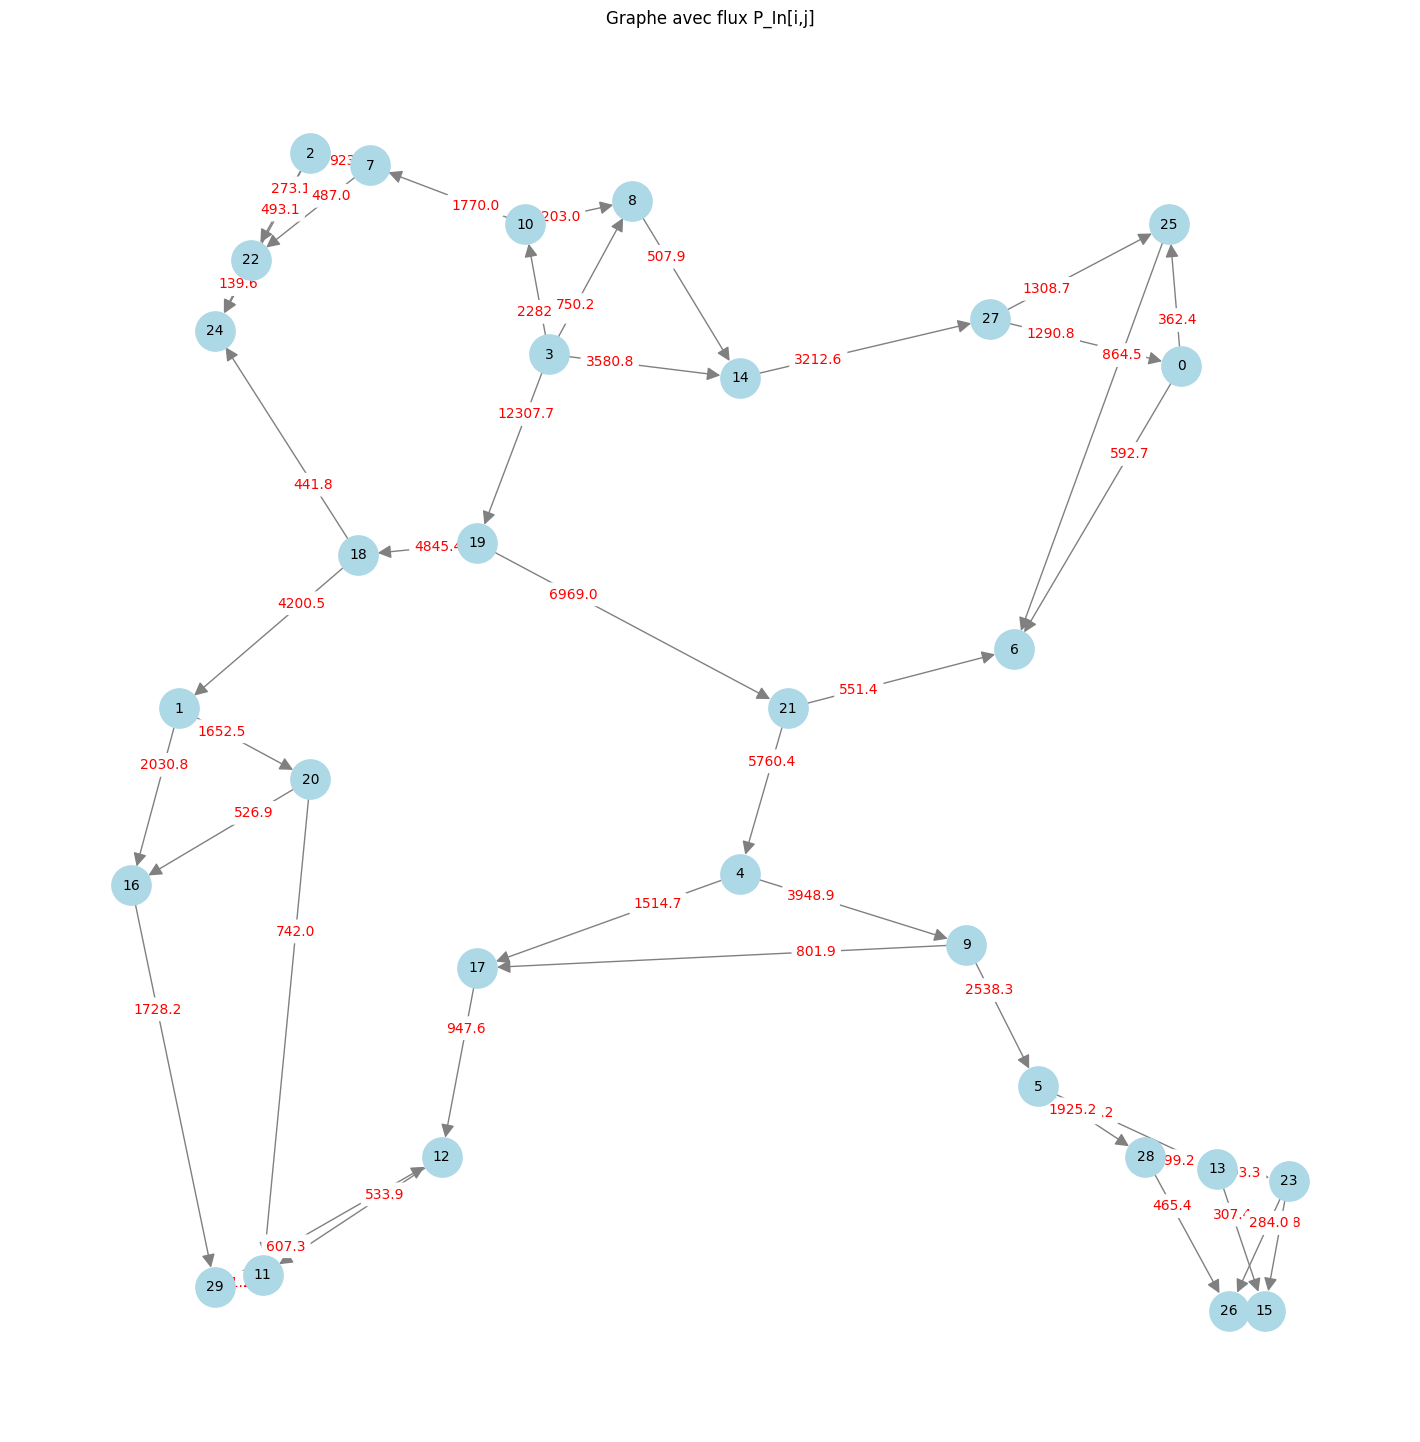

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Créer un graphe orienté
G = nx.DiGraph()

# Ajouter les nœuds
G.add_nodes_from(V)

# Extraire les arêtes actives (X[i][j] = 1) et les flux associés
edges = []
edge_labels = {}
for var in problem.variables():
    if var.name.startswith("X_") and var.varValue == 1:
        # Extraire i et j
        parts = var.name.split("_")
        i = int(parts[1])
        j = int(parts[2])
        edges.append((i, j))

        # Récupérer la valeur de P_In[i][j]
        p_in_var = next((v for v in problem.variables() if v.name == f"P_In_{i}_{j}"), None)
        if p_in_var:
            edge_labels[(i, j)] = f"{p_in_var.varValue:.1f}"

# Ajouter les arêtes au graphe
G.add_edges_from(edges)

# This is necessary for using is_k_edge_connected
undirected_G = G.to_undirected()

# Now you can check for k-edge connectivity on the undirected graph
print(list(nx.k_edge_augmentation(undirected_G, 2)))

# Positions des nœuds (depuis NodesCord)
pos = {node: (float(NodesCord[node][0]), float(NodesCord[node][1])) for node in NodesCord}

# Dessiner le graphe
plt.figure(figsize=(14, 14))
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=800,
        edge_color='gray', arrows=True, arrowsize=20, font_size=10)

# Ajouter les labels de flux
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red',
                             label_pos=0.3, rotate=False)

plt.title("Graphe avec flux P_In[i,j]")
plt.show()